# gmsh examples

## Mobius strip

### Plot by Matplotlib

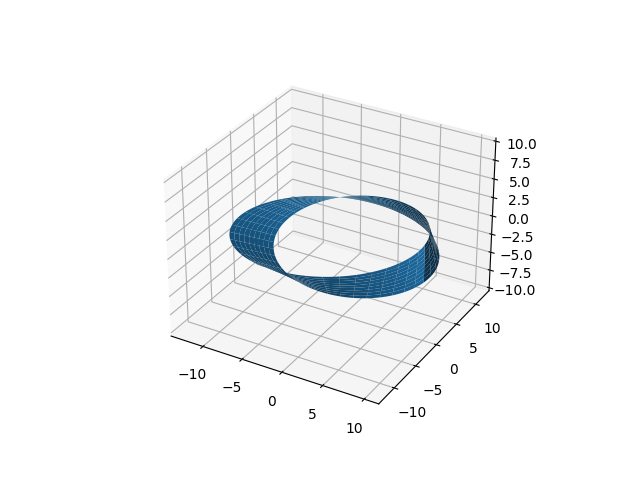

In [6]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt

# for interactive figures
%matplotlib widget

R = 10
W = 5

_u = np.linspace(0, 2*np.pi, 201, endpoint=True)
_v = np.linspace(-1/2, 1/2, 10)
u, v = np.meshgrid(_u, _v)

r = R - W*v*np.sin(u/2)
x = r*np.cos(u)
y = r*np.sin(u)
z = W*v*np.cos(u/2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z)
zlim = ax.set_zlim([-2*W, 2*W])

### Python script

In [2]:
import sys
import gmsh
import numpy as np

gmsh.initialize()
fac = gmsh.model.geo
R = 5
W = 2
M = 50
_u = np.linspace(0, 2*np.pi, M+1, endpoint=True)
_v = np.linspace(-1/2, 1/2, 2)
u, v = np.meshgrid(_u, _v)

r = R - W*v*np.sin(u/2)
x = r*np.cos(u)
y = r*np.sin(u)
z = W*v*np.cos(u/2)

points = [[], []]

line_current = None
ss = []
for i in range(M):
    points[0].append(fac.add_point(x[0, i], y[0, i], z[0, i]))
    points[1].append(fac.add_point(x[1, i], y[1, i], z[1, i]))
    line_pre = line_current
    line_current = fac.add_line(points[0][-1], points[1][-1])
    
    if i == 0:
        line0 = line_current
    else:
        j = i - 1
        line3 = fac.add_line(points[0][i-1], points[0][i])
        line4 = fac.add_line(points[1][i-1], points[1][i])


        cl = fac.add_curve_loop([line_pre, line4, -line_current, -line3])
        ss.append(fac.add_plane_surface([cl]))

line3 = fac.add_line(points[0][-1], points[1][0])
line4 = fac.add_line(points[1][-1], points[0][0])
cl = fac.add_curve_loop([line_current, line4, line0, -line3])
ss.append(fac.add_plane_surface([cl]))

fac.add_surface_loop(ss)
fac.synchronize()

h = 0.4
gmsh.option.setNumber("Mesh.MeshSizeMin", h)
gmsh.option.setNumber("Mesh.MeshSizeMax", h)

__old_verbosity = gmsh.option.getNumber("General.Verbosity")
gmsh.option.setNumber("General.Verbosity", 1)
# TODO: catch the exception of gmsh
gmsh.model.mesh.generate()
gmsh.option.setNumber("General.Verbosity", __old_verbosity)

gmsh.write('mobius.msh') 

# gui or not
if '-popup' in sys.argv:
    gmsh.fltk.run()


gmsh.finalize()

Info    : Writing 'mobius.msh'...
Info    : Done writing 'mobius.msh'


### Solve Possion problem on Mobius strip

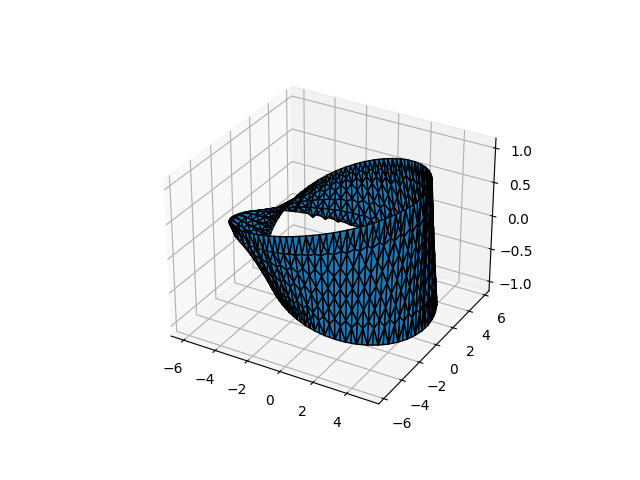

In [3]:
from firedrake import *

msh = Mesh('mobius.msh', dim=3)
triplot(msh)

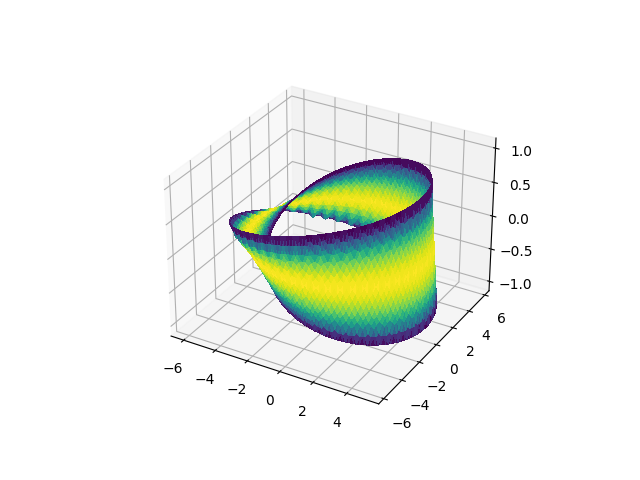

In [4]:
x, y, z = SpatialCoordinate(msh)
f = x**2 + y**2 + z**2

V = FunctionSpace(msh, 'CG', 1)
u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx - inner(f, v)*dx

u = Function(V)
bc = DirichletBC(V, 0, 'on_boundary')
solve(lhs(a) == rhs(a), u, bcs=bc)

trisurf(u)